In [12]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import eigvalsh 


## Plotting using finite-difference gradients

In [13]:
# parameters and functions
sigma_q = 1.5 
beta = 1.0   
n_samples = 5000  
eps = 1e-5  

# generate data
X = np.random.randn(n_samples) * sigma_q  # x ~ N(0, sigma_q^2)
V = np.random.randn(n_samples)            # v ~ N(0, 1)

# make a grid search space
a_vals = np.linspace(-5, 5, 40)
b_vals = np.linspace(-5, 5, 40)
A, B = np.meshgrid(a_vals, b_vals, indexing='xy')

In [14]:
# Loss functions
 
def loss_Lf(a, b):
    f_x = a * X**3
    Jf = 3 * a * X**2
    Jf_safe = np.where(np.abs(Jf) < eps, eps, Jf)  # division by zero
    prior = 0.5 * f_x**2                     # -log p(f(x)) for p = N(0,1)
    jac = -np.log(np.abs(Jf_safe))            # -log(det(J(f(x)))
    spread = - (V**2) / Jf_safe               # -v^T J_f^{-1} v
    recon = beta * (X - b * f_x)**2           # Reconstruction term (ad-hoc)

    return np.mean(prior + jac + spread + recon)

def loss_Lg(a, b):
    f_x = a * X**3
    Jf = 3 * a * X**2
    Jf_safe = np.where(np.abs(Jf) < eps, eps, Jf)
    prior = 0.5 * f_x**2                     # -log p(f(x))
    jac = -np.log(np.abs(Jf_safe))            # -log|J_f|
    spread = -9 * a**3 * b * X**8 * V**2        # -v^T J_g J_f^{-1} v (J_g = b)
    recon = beta * (X - b * (f_x)**3)**2       # Reconstruction term

    return np.mean(prior + jac + spread + recon)

In [15]:
# define gradients as "infinitesimally" small steps
def grad_fd(loss_fn, a, b):
    la_p = loss_fn(a + eps, b)
    la_m = loss_fn(a - eps, b)
    lb_p = loss_fn(a, b + eps)
    lb_m = loss_fn(a, b - eps)
    da = (la_p - la_m) / (2 * eps)
    db = (lb_p - lb_m) / (2 * eps)
    return da, db


# Compute gradients over grid
grad_a_Lf = np.zeros_like(A)
grad_b_Lf = np.zeros_like(A)
grad_a_Lg = np.zeros_like(A)
grad_b_Lg = np.zeros_like(A)

In [16]:
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        a, b = A[i, j], B[i, j]
        grad_a_Lf[i, j], grad_b_Lf[i, j] = grad_fd(loss_Lf, a, b)
        grad_a_Lg[i, j], grad_b_Lg[i, j] = grad_fd(loss_Lg, a, b)

In [17]:
# Gradient magnitudes
mag_Lf = np.sqrt(grad_a_Lf**2 + grad_b_Lf**2)
mag_Lg = np.sqrt(grad_a_Lg**2 + grad_b_Lg**2)

# Detect critical points (bottom 1% of the gradient magnitude valyes)
threshold_Lf = np.percentile(mag_Lf, 1)
threshold_Lg = np.percentile(mag_Lg, 1)

# thresholding
crit_indices_Lf = np.argwhere(mag_Lf < threshold_Lf)
crit_indices_Lg = np.argwhere(mag_Lg < threshold_Lg)

# making the indices plot ready
crit_points_Lf = np.column_stack((A[crit_indices_Lf[:, 0], crit_indices_Lf[:, 1]],
                                 B[crit_indices_Lf[:, 0], crit_indices_Lf[:, 1]]))
crit_points_Lg = np.column_stack((A[crit_indices_Lg[:, 0], crit_indices_Lg[:, 1]],
                                 B[crit_indices_Lg[:, 0], crit_indices_Lg[:, 1]]))

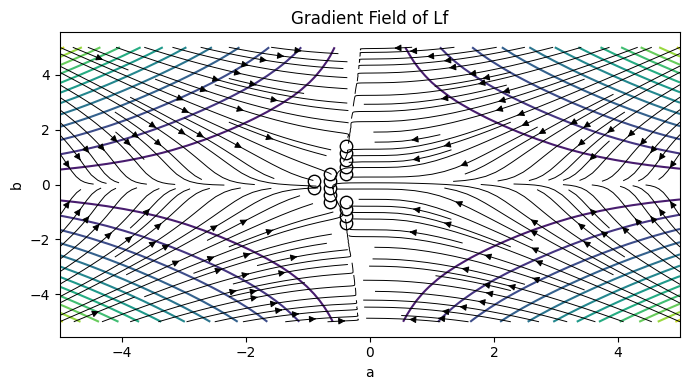

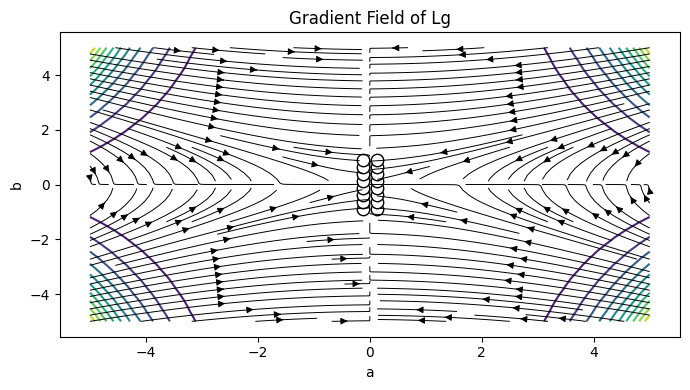

In [18]:
# plotting gradient plots along with the Critical points
def plot_gradient_field(A, B, grad_a, grad_b, mag, crit_points, title):
    plt.figure(figsize=(7,4))
    plt.contour(A, B, mag, levels=12, cmap='viridis')
    plt.streamplot(A, B, -grad_a, -grad_b, density=1.5, color='k', linewidth=0.7)
    plt.scatter(crit_points[:, 0], crit_points[:, 1], c='white', edgecolor='black', s=80)
    plt.xlabel('a'); plt.ylabel('b')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_gradient_field(A, B, grad_a_Lf, grad_b_Lf, mag_Lf, crit_points_Lf, "Gradient Field of Lf")
plot_gradient_field(A, B, grad_a_Lg, grad_b_Lg, mag_Lg, crit_points_Lg, "Gradient Field of Lg")


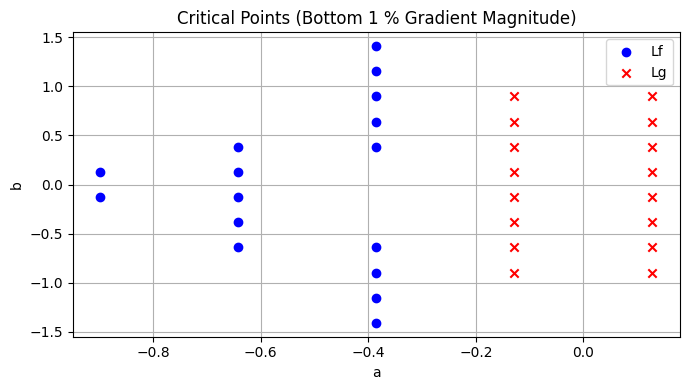

In [19]:
# are the critical points overlapping? - highly unlikely: 
plt.figure(figsize=(7,4))
plt.scatter(crit_points_Lf[:, 0],  crit_points_Lf[:, 1],
            c='blue',  marker='o',  label='Lf')          # circles
plt.scatter(crit_points_Lg[:, 0],  crit_points_Lg[:, 1],
            c='red',   marker='x',  label='Lg')          # x-marks

plt.xlabel("a")
plt.ylabel("b")
plt.title("Critical Points (Bottom 1 % Gradient Magnitude)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Interpretation: 
We see that although the gradients contours look similar overall (as expected), the critical points here are different with some potential overlaps. 

2 sources of error on my end: 
1. Of course, I have calculated gradients using a finite limits based definition and not pre-implemented. (Done in the next part using JAX)
2. Definition of thresholds is rather arbitrary 

## Plotting using package calculated gradients

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import grad, vmap, jit

jax.config.update("jax_enable_x64", True) 

In [4]:
sigma_q = 1.5
beta    = 1.0
n_data  = 5_000                         
# sampling using jax
key_x, key_v = jax.random.split(jax.random.PRNGKey(0))

X = jax.random.normal(key_x, (n_data,)) * sigma_q  
V = jax.random.normal(key_v, (n_data,))             #
eps = 1e-8   

In [5]:
# loss functions that use jax numpy, otherwise the exxact same

def loss_Lf(a, b):
    f_x   = a * X**3
    Jf    = 3 * a * X**2
    Jf_safe = jnp.where(jnp.abs(Jf) < eps, eps, Jf)

    prior  = 0.5 * f_x**2 + 0.5 * np.log(2 * np.pi)                
    jac    = -jnp.log(jnp.abs(Jf_safe))  
    spread = -(V**2) / Jf_safe       
    recon  = beta * (X - b * f_x)**2        

    return jnp.mean(prior + jac + spread + recon)

def loss_Lg(a, b):
    f_x = a * X**3
    Jf = 3 * a * X**2
    Jf_safe = jnp.where(jnp.abs(Jf) < eps, eps, Jf)
    
    prior = 0.5 * f_x**2 + 0.5 * jnp.log(2 * jnp.pi)
    jac = -jnp.log(jnp.abs(Jf_safe))
    
    spread = -9 * a**3 * b * X**8 * V**2
    recon = beta * (X - b * (f_x)**3)**2
    
    return jnp.mean(prior + jac + spread + recon)


In [6]:
# jit compile gradients
grad_Lf = jit(grad(loss_Lf, argnums=(0, 1)))   
grad_Lg = jit(grad(loss_Lg, argnums=(0, 1)))

a_vals = jnp.linspace(-5, 5, 40)
b_vals = jnp.linspace(-5, 5, 40)
A, B   = jnp.meshgrid(a_vals, b_vals, indexing='xy')

# flatten → vmap → reshape  (evaluates on 81×81 points)
a_flat = A.ravel()
b_flat = B.ravel()

grad_flat_Lf_da, grad_flat_Lf_db = vmap(grad_Lf)(a_flat, b_flat)
grad_flat_Lg_da, grad_flat_Lg_db = vmap(grad_Lg)(a_flat, b_flat)

# reshape onto the (a,b) grid
grad_a_Lf = grad_flat_Lf_da.reshape(A.shape)
grad_b_Lf = grad_flat_Lf_db.reshape(A.shape)
grad_a_Lg = grad_flat_Lg_da.reshape(A.shape)
grad_b_Lg = grad_flat_Lg_db.reshape(A.shape)

In [7]:
# critical point detection below a threshold

mag_Lf = jnp.sqrt(grad_a_Lf**2 + grad_b_Lf**2)# magnitude over a,b or the loss function
mag_Lg = jnp.sqrt(grad_a_Lg**2 + grad_b_Lg**2)

tol = 1e-3

mask_Lf = mag_Lf < tol
if mask_Lf.sum() == 0:
    thresh_Lf = jnp.percentile(mag_Lf, 1)
    mask_Lf = mag_Lf < thresh_Lf

crit_Lf = jnp.argwhere(mask_Lf)
crit_pts_Lf = jnp.column_stack((A[crit_Lf[:, 0], crit_Lf[:, 1]],
                                B[crit_Lf[:, 0], crit_Lf[:, 1]]))
                                
mask_Lg = mag_Lg < tol
if mask_Lg.sum() == 0:
    thresh_Lg = jnp.percentile(mag_Lg, 1)
    mask_Lg = mag_Lg < thresh_Lg

crit_Lg = jnp.argwhere(mask_Lg)
crit_pts_Lg = jnp.column_stack((A[crit_Lg[:, 0], crit_Lg[:, 1]],
                                B[crit_Lg[:, 0], crit_Lg[:, 1]]))



In [8]:
# plotting helpers
A_np, B_np         = np.array(A), np.array(B)
grad_a_Lf_np       = np.array(grad_a_Lf); grad_b_Lf_np = np.array(grad_b_Lf)
grad_a_Lg_np       = np.array(grad_a_Lg); grad_b_Lg_np = np.array(grad_b_Lg)
crit_pts_Lf_np     = np.array(crit_pts_Lf)
crit_pts_Lg_np     = np.array(crit_pts_Lg)

def plot_grad_field(A, B, ga, gb, crit, title):
    plt.figure(figsize=(6,5))
    plt.contour(A, B, np.sqrt(ga**2 + gb**2), levels=15, cmap='viridis')
    plt.streamplot(A, B, -ga, -gb, density=1.4, color='k', linewidth=0.7)
    if len(crit):
        plt.scatter(crit[:,0], crit[:,1], s=80, c='white', edgecolors='black')
    plt.xlabel('a'); plt.ylabel('b'); plt.title(title); plt.tight_layout(); plt.show()



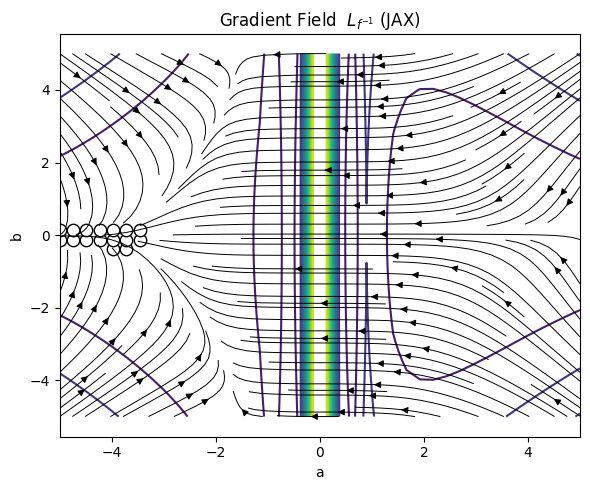

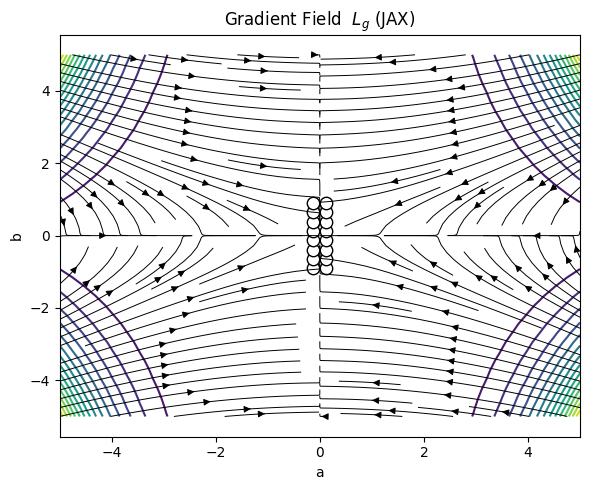

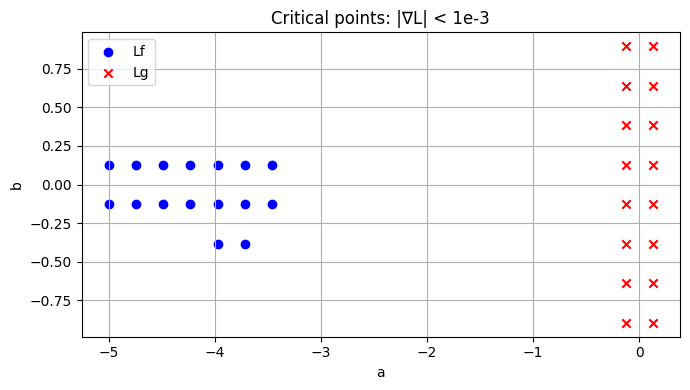

In [9]:
# plotting

plot_grad_field(A_np, B_np, grad_a_Lf_np, grad_b_Lf_np,
                crit_pts_Lf_np, 'Gradient Field  $L_{f^{-1}}$ (JAX)')

plot_grad_field(A_np, B_np, grad_a_Lg_np, grad_b_Lg_np,
                crit_pts_Lg_np, 'Gradient Field  $L_{g}$ (JAX)')

# Combined critical-point scatter
plt.figure(figsize=(7,4))
plt.scatter(crit_pts_Lf_np[:,0], crit_pts_Lf_np[:,1],
            c='blue', marker='o', label='Lf')
plt.scatter(crit_pts_Lg_np[:,0], crit_pts_Lg_np[:,1],
            c='red',  marker='x', label='Lg')
plt.legend(); plt.grid(True); plt.xlabel('a'); plt.ylabel('b')
plt.title('Critical points: |∇L| < 1e-3'); plt.tight_layout(); plt.show()

### Final comments: 

Even if the implementations are perfect and they end up matching the paper's claims this is still not enough in my opinion. 
Their condition of f_theta being globally invertible is a gross simplification and would definitely not hold in most scenarios where one would want to apply FFF. 